Loading Conditions

1. Wing (Horizontal)
- a. Distributed Load (Lift)
- b. Weight of entire plane in middle of beam (overestimate)

2. Wing (Vertical)
- Weight of entire plane in middle of beam * (g + 1)
    - +1 to account for plane's inertia while rising

3. Wing to Tail (1.4m Cantilever Beam)
- a. Weight of tail at end 
- b. Pitching moment (1Nm for now, make it variable)

4. Motor to Motor (1.2m between motors, tentatively add 10 cm to each end)
- a. Pinned at motor locations
- b. Weight of plane (at some point along the beam, make variable)

In [262]:
import matplotlib.pyplot as plt
import numpy as np
import sympy as sp
import pandas as pd
import scipy.integrate as integrate

In [263]:
inchToM = 0.0254
msiToPA = 6.8948*10**9

plane_mass = 10         # kg
g = 9.81                # N/kg

W_plane = plane_mass * g        # N | weight of plane acting in middle of wing spar
W_plane2 = plane_mass * (g+1)   # N | effective weight of plane in vertical flight

# WING SPAR

# Inboard / Motor to Motor
E1 = 33      # msi
ID1 = 0.75   # inch
OD1 = 0.83   # inch
I1 = ((np.pi)/64) * ((OD1*inchToM)**4-(ID1*inchToM)**4)  # m^4

# Outboard
E2 = 33       # msi
ID2 = 0.625   # inch
OD2 = 0.705   # inch
I2 = ((np.pi)/64) * ((OD2*inchToM)**4-(ID2*inchToM)**4)  # m^4

pin_a = -0.5
pin_b = 0.5

# WING TO TAIL SPAR
E3 = 55      # msi
ID3 = 0.938  # inch
OD3 = 1.008  # inch
I3 = ((np.pi)/64) * ((OD3*inchToM)**4-(ID3*inchToM)**4)  # m^4

tail_mass = 0.25        # kg
W_tail = tail_mass * g  # N acting on end of wing to tail spar
pitchMoment = 1         # Nm
wing_tail_length = 1.4  # m

# MOTOR TO MOTOR SPAR

load_location = 0.7 # m | location of load measured from front of plane
motor1 = 0.1        # m | location of front motor
motor2 = 1.3        # m | location of back motor
a = load_location - motor1  # m | distance between front motor and load
b = motor2 - load_location  # m | distance between back motor and load

$$Lift = C_l \frac{1}{2}\rho v^2 A $$

In [264]:
rho = 1.225 # kg/m^3
v = 18 # m/s

106.54863880697626

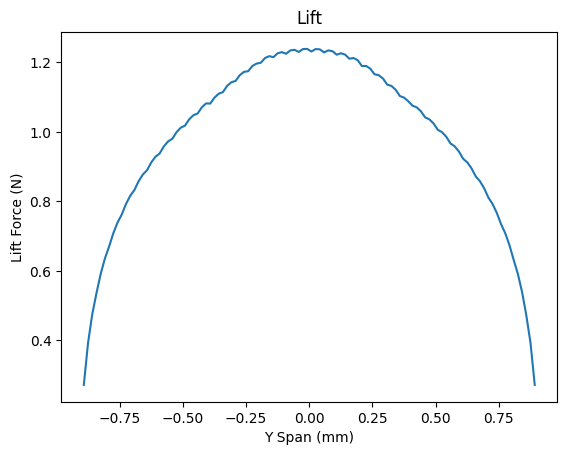

In [265]:
df = pd.read_csv('Wing_Data.csv')
df['area'] = df['del_y']*df['Chord']
df['lift'] = df['area']*df['cl']*0.5*rho*v**2
plt.plot(df['y_span'],df['lift'])

plt.title("Lift")
plt.xlabel("Y Span (mm)")
plt.ylabel("Lift Force (N)")

totalLift = sum(df['lift'])
totalLift

Text(0, 0.5, 'Shear Force (N)')

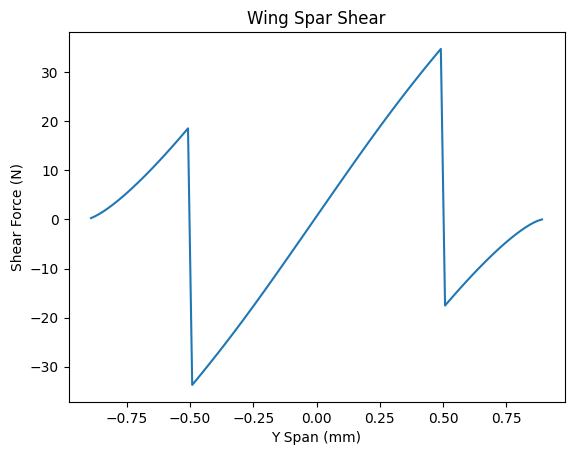

In [266]:
wing = pd.DataFrame()
wing['y_span'] = df['y_span']
wing['lift'] = df['lift']
pinReaction = totalLift/2

shear = []
total = 0

for index, row in wing.iterrows():
    if row['y_span'] < pin_a: # to left of pin a
        total += row['lift']
        shear.append(total)
        
total -= pinReaction

for index, row in wing.iterrows():
    if row['y_span'] > pin_a and row['y_span'] < 0: # between pin a and center
        total += row['lift']
        shear.append(total)

for index, row in wing.iterrows():
    if row['y_span'] > 0 and row['y_span'] < pin_b: # between center and pin b
        total += row['lift']
        shear.append(total)

total -= pinReaction

for index, row in wing.iterrows():
    if row['y_span'] >= pin_b: # to left of pin a
        total += row['lift']
        shear.append(total)

plt.plot(wing['y_span'],shear)

plt.title("Wing Spar Shear")
plt.xlabel("Y Span (mm)")
plt.ylabel("Shear Force (N)")

Text(0, 0.5, 'Moment (Nm)')

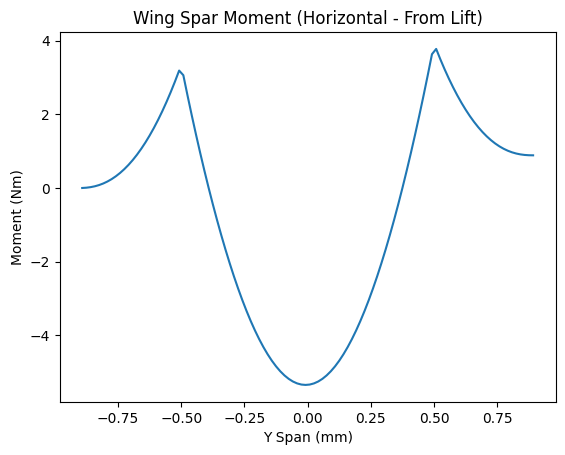

In [267]:
moment1a = integrate.cumulative_trapezoid(shear,wing['y_span'],initial = 0)

plt.plot(wing['y_span'],moment1a)

plt.title("Wing Spar Moment (Horizontal - From Lift)")
plt.xlabel("Y Span (mm)")
plt.ylabel("Moment (Nm)")

Text(0, 0.5, 'Moment (Nm)')

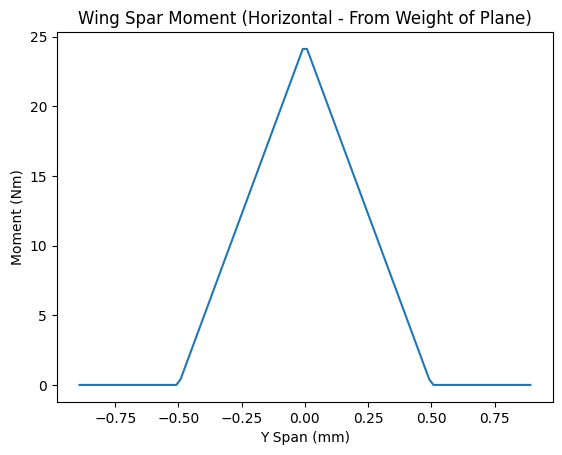

In [268]:
moment1b = []

for index, row in wing.iterrows():
    if row['y_span'] < pin_a: # to left of pin a
        moment1b.append(0)
    elif row['y_span'] > pin_a and row['y_span'] < 0: # between pin a and center
        moment1b.append((W_plane/2) * (row['y_span']-pin_a))
    elif row['y_span'] > 0 and row['y_span'] < pin_b: # between center and pin b
        moment1b.append((W_plane/2) * (pin_b-row['y_span'])) 
    else: #to the right of pin b
        moment1b.append(0)


plt.plot(wing['y_span'],moment1b)

plt.title("Wing Spar Moment (Horizontal - From Weight of Plane)")
plt.xlabel("Y Span (mm)")
plt.ylabel("Moment (Nm)")

Text(0, 0.5, 'Moment (Nm)')

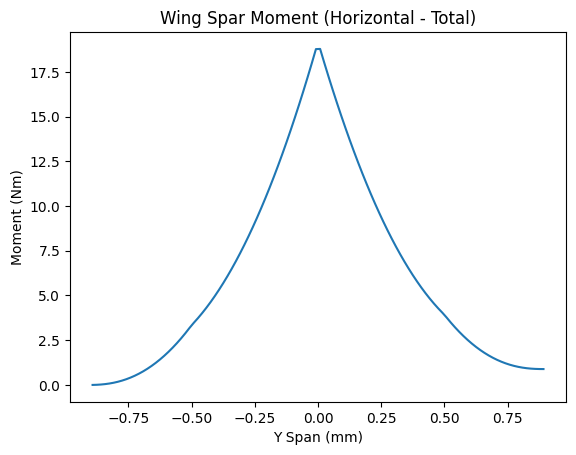

In [269]:
moment1 = np.add(moment1a, moment1b)

plt.plot(wing['y_span'],moment1)

plt.title("Wing Spar Moment (Horizontal - Total)")
plt.xlabel("Y Span (mm)")
plt.ylabel("Moment (Nm)")

5.490058772870666 mm
122.5338463453105 MPa


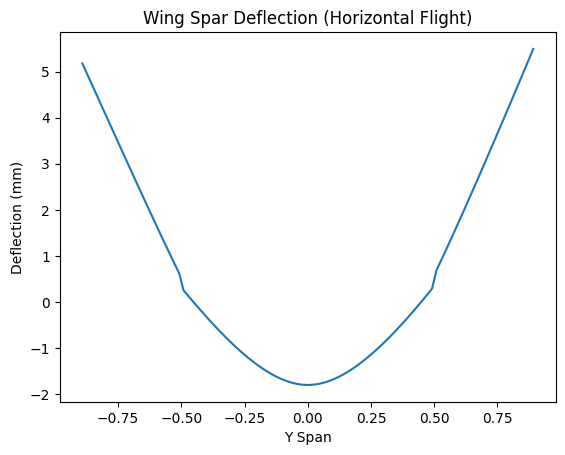

In [270]:

theta = integrate.cumulative_trapezoid(moment1, wing['y_span'],initial = 0)
theta = integrate.cumulative_trapezoid(moment1, wing['y_span'], initial=0)
theta -= np.median(theta)
#plt.plot(wing['y_span'], theta,label = 'theta')
displacement1 = integrate.cumulative_trapezoid(theta, wing['y_span'], initial=0)
displacement1 -= np.median(displacement1)
#plt.plot(wing['y_span'], displacement1,label = 'displacement')

displacement1_scaled = []

for index, row in wing.iterrows():
    if row['y_span'] > pin_a and row['y_span'] < pin_b: # between pin a and pin b (inboard)
        displacement1_scaled.append((displacement1[index]/((E1*msiToPA)*I1))*1000)
    else: #to the left of pin a or the right of pin b (outboard)
        displacement1_scaled.append((displacement1[index]/((E2*msiToPA)*I2))*1000)

plt.plot(wing['y_span'], displacement1_scaled,label = 'displacement')

plt.title("Wing Spar Deflection (Horizontal Flight)")
plt.xlabel("Y Span")
plt.ylabel("Deflection (mm)")

d1_max = max(displacement1_scaled)
print(d1_max, "mm")

stress1_max = ((max(moment1) * OD1*inchToM) / I1) / 10**6
print(stress1_max, "MPa")

Text(0, 0.5, 'Moment (Nm)')

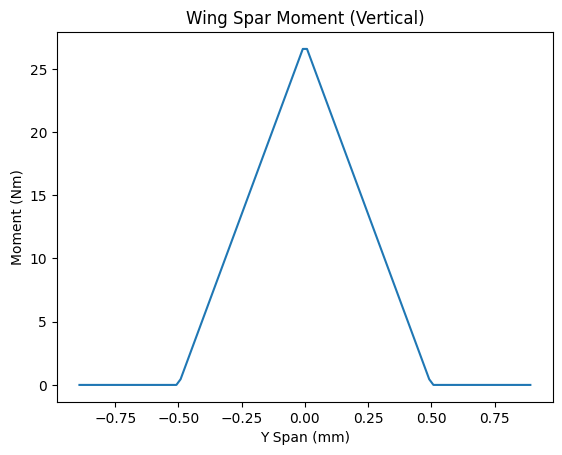

In [271]:
moment2 = []

for index, row in wing.iterrows():
    if row['y_span'] < pin_a: # to left of pin a
        moment2.append(0)
    elif row['y_span'] > pin_a and row['y_span'] < 0: # between pin a and center
        moment2.append((W_plane2/2) * (row['y_span']-pin_a))
    elif row['y_span'] > 0 and row['y_span'] < pin_b: # between center and pin b
        moment2.append((W_plane2/2) * (pin_b-row['y_span'])) 
    else: #to the right of pin b
        moment2.append(0)


plt.plot(wing['y_span'],moment2)

plt.title("Wing Spar Moment (Vertical)")
plt.xlabel("Y Span (mm)")
plt.ylabel("Moment (Nm)")

4.056480487460461 mm
173.36432212802163 MPa


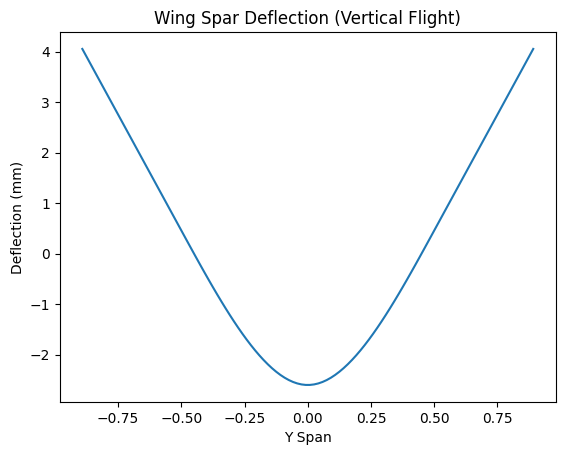

In [272]:
theta = integrate.cumulative_trapezoid(moment2, wing['y_span'],initial = 0)
theta = integrate.cumulative_trapezoid(moment2, wing['y_span'], initial=0)
theta -= np.median(theta)

displacement2 = integrate.cumulative_trapezoid(theta, wing['y_span'], initial=0)
displacement2 -= np.median(displacement2)

displacement2_scaled = []

for x in displacement2:
    displacement2_scaled.append((x/((E1*msiToPA)*I1))*1000)

plt.plot(wing['y_span'], displacement2_scaled,label = "Displacement (Vertical)")

plt.title("Wing Spar Deflection (Vertical Flight)")
plt.xlabel("Y Span")
plt.ylabel("Deflection (mm)")

d2_max = max(displacement2_scaled)
print(d2_max, "mm")

stress2_max = ((max(moment2) * OD1*inchToM) / I1) / 10**6
print(stress2_max, "MPa")

-1.6108039520388986 mm
21.51186487623072 MPa


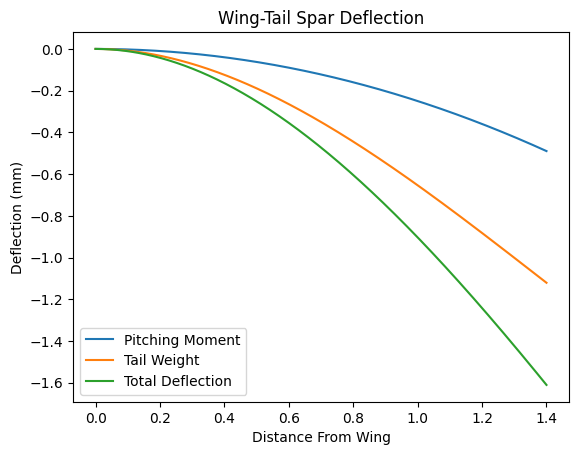

In [273]:
displacement3a = []
displacement3b = []

dist = np.linspace(0, 1.4, 1000)

for x in dist:
    displacement3a.append(-(((W_tail * x**2) / (6*(E3*msiToPA)*I3)) * (3*wing_tail_length - x)) * 1000)

for x in dist:
    displacement3b.append(-((pitchMoment * x**2) / (2*(E3*msiToPA)*I3)) * 1000)

displacement3 = np.add(displacement3a, displacement3b)


plt.plot(dist, displacement3b, label = "Pitching Moment")

plt.plot(dist, displacement3a, label = "Tail Weight")

plt.plot(dist, displacement3, label = "Total Deflection")

plt.title("Wing-Tail Spar Deflection")
plt.xlabel("Distance From Wing")
plt.ylabel("Deflection (mm)")
plt.legend()

d3_max = max(displacement3, key=abs)
print(d3_max, "mm")

stress3_max = (((W_tail*wing_tail_length + 1) * OD3*inchToM) / I3) / 10**6
print(stress3_max, "MPa")

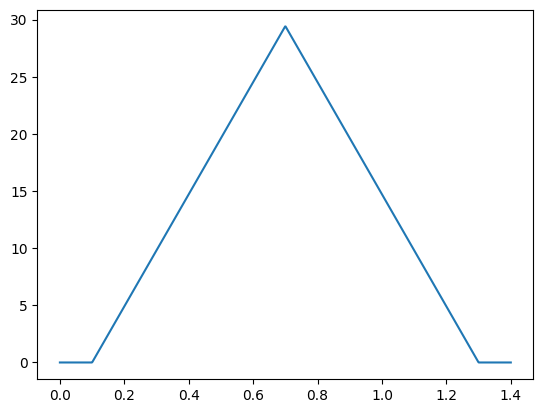

In [274]:
moment4 = []

dist = np.linspace(0, 1.4, 1000)

motor1Reaction = ((motor2-load_location) / (motor2-motor1)) * W_plane

motor2Reaction = ((load_location-motor1) / (motor2-motor1)) * W_plane

for x in dist:
    if x < motor1:
        moment4.append(0)
    elif x > motor1 and x <= load_location:
        moment4.append((x-motor1) * motor1Reaction)
    elif x >= load_location and x < motor2:
        moment4.append((motor2-x) * motor2Reaction)
    else:
        moment4.append(0)

plt.plot(dist, moment4)


6.74133668577013 mm
191.75495756119537 MPa


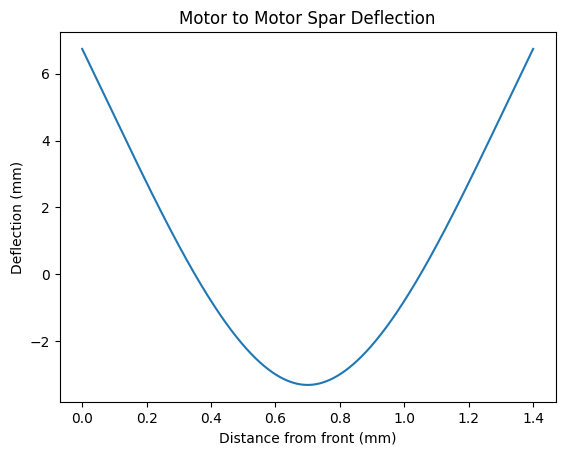

In [275]:
theta = integrate.cumulative_trapezoid(moment4, dist, initial = 0)
theta = integrate.cumulative_trapezoid(moment4, dist, initial = 0)
theta -= np.median(theta)

displacement4 = integrate.cumulative_trapezoid(theta, dist, initial=0)
displacement4 -= np.median(displacement4)

displacement4_scaled = []

for x in displacement4:
    displacement4_scaled.append((x/((E2*msiToPA)*I2))*1000)

plt.plot(dist, displacement4_scaled,label = "Displacement")

plt.title("Motor to Motor Spar Deflection")
plt.xlabel("Distance from front (mm)")
plt.ylabel("Deflection (mm)")

d4_max = max(displacement4_scaled)
print(d4_max, "mm")

stress4_max = ((max(moment4) * OD1*inchToM) / I1) / 10**6
print(stress4_max, "MPa")

In [276]:
print("Wing (Horizontal Flight)")
print("Max Displacement:", "%.3f" % round(d1_max, 3), "mm")
print("Max Bending Stress:", "%.3f" % round(stress1_max, 3), "MPa")
print()
print("Wing (Vertical Flight)")
print("Max Displacement:", "%.3f" % round(d2_max, 3), "mm")
print("Max Bending Stress:", "%.3f" % round(stress2_max, 3), "MPa")
print()
print("Wing to Tail")
print("Max Displacement:", "%.3f" % round(d3_max, 3), "mm")
print("Max Bending Stress:", "%.3f" % round(stress3_max, 3), "MPa")
print()
print("Motor to Motor")
print("Max Displacement:", "%.3f" % round(d4_max, 3), "mm")
print("Max Bending Stress:", "%.3f" % round(stress4_max, 3), "MPa")

Wing (Horizontal Flight)
Max Displacement: 5.490 mm
Max Bending Stress: 122.534 MPa

Wing (Vertical Flight)
Max Displacement: 4.056 mm
Max Bending Stress: 173.364 MPa

Wing to Tail
Max Displacement: -1.611 mm
Max Bending Stress: 21.512 MPa

Motor to Motor
Max Displacement: 6.741 mm
Max Bending Stress: 191.755 MPa
